# Todo List
- Add several dense layers after convolutional layers
- Play with learning rate and batch size
- Shuffle dataset after each epoch
- Add skip layers

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import helper
import os

dataset_dir = 'DataSet/'

# Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


# Import Data

In [3]:
count = 0
for filename in os.listdir(dataset_dir):
    if filename.endswith("test_set.pkl") or filename.endswith("predict.pkl") or filename.endswith("debug.pkl"):
        continue
    if filename.endswith(".pkl"): 
        df = pd.read_pickle(os.path.join(dataset_dir, filename))
        
        if count == 0:
            raw_df = df
        else:
            raw_df = raw_df.append(df, ignore_index=True)
            
        print('File: {}, DataSet Length: {}'.format(os.path.join(dataset_dir, filename), len(df)))
        count += 1
    else:
        continue
print('Total Length: {}'.format(len(raw_df)))

File: DataSet/2018-07-13_18-39-56_0.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-43-51_0.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-46-04_1.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-47-58_2.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-49-54_3.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-52-16_4.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-54-29_5.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-56-38_6.pkl, DataSet Length: 500
File: DataSet/2018-07-13_18-58-30_7.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-00-21_8.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-02-36_9.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-04-42_10.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-06-38_11.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-08-49_12.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-10-48_13.pkl, DataSet Length: 500
File: DataSet/2018-07-13_19-12-43_14.pkl, DataSet Length: 500
File: DataSet/2018-

In [4]:
data_width = len(raw_df['data'][0])

# Data Preprocessing

#### Filter out key counts less than threshold value

In [5]:
import collections
import matplotlib.pyplot as plt

key_count = collections.Counter(raw_df['key']) # List of key count in dataset

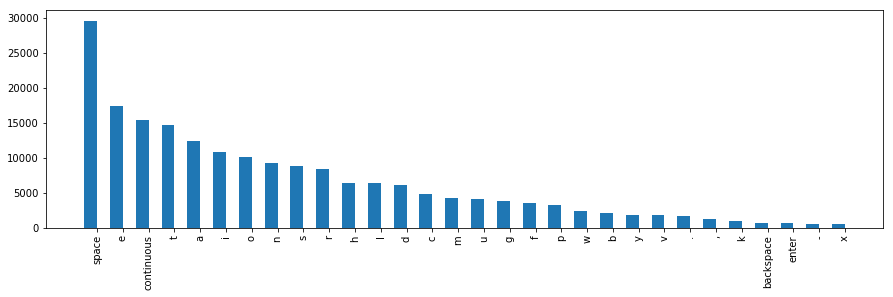

<bound method Counter.most_common of Counter({'space': 29557, 'e': 17443, 'continuous': 15366, 't': 14658, 'a': 12361, 'i': 10861, 'o': 10084, 'n': 9276, 's': 8834, 'r': 8391, 'h': 6412, 'l': 6325, 'd': 6082, 'c': 4759, 'm': 4234, 'u': 4130, 'g': 3835, 'f': 3486, 'p': 3259, 'w': 2423, 'b': 2087, 'y': 1844, 'v': 1813, '.': 1711, ',': 1209, 'k': 903, 'backspace': 742, 'enter': 731, '-': 493, 'x': 477, 'z': 395, 'j': 272, 'shift': 267, "'": 219, 'q': 207, '0': 179, '1': 112, '2': 102, '5': 74, '9': 61, ';': 61, 'ctrl_l': 60, '3': 59, 'down': 38, 'delete': 38, '4': 35, '/': 29, '7': 26, '8': 26, '6': 24, 'esc': 17, 'left': 16, 'up': 10, 'right': 8, '=': 4, 'tab': 4, '`': 1})>

In [6]:
helper.plot_key_hist(key_count.most_common())
key_count.most_common

In [7]:
# Maximize DataSet Size By Finding Optimal Threshold
max_data_size, max_class_cnt, threshold_max = helper.get_optimized_threshold(key_count)
print('Max Data Size: {}, Class Count: {}, Threshold: {}'.format(max_data_size, max_class_cnt, threshold_max))

# OR, Manually define threshold
#threshold_max = 3048

Max Data Size: 83910, Class Count: 10, Threshold: 8390


#### Get Key Classes

In [8]:
# Get list of keys with counts greater than threshold
threshold = threshold_max
min_thresh_keys = [key for key, count in zip(key_count.keys(), key_count.values()) if count > threshold]

# Save list of key classes to pickle
pickle.dump(min_thresh_keys, open(os.path.join(dataset_dir, "key_classes.p"), "wb"))

#### Filter Data Set

In [9]:
min_thresh_df = raw_df[raw_df['key'].isin(min_thresh_keys)] # Filter dataframe to only include keys > threshold

In [10]:
def trim_max_thresh(grouped_class):
    return grouped_class.sample(threshold)

In [11]:
# Keep same number of samples in each class by throwing away everything past the threshold
df = min_thresh_df.groupby(['key']).apply(trim_max_thresh)

#### Plot truncated data

In [12]:
truncated_count = collections.Counter(df['key'])

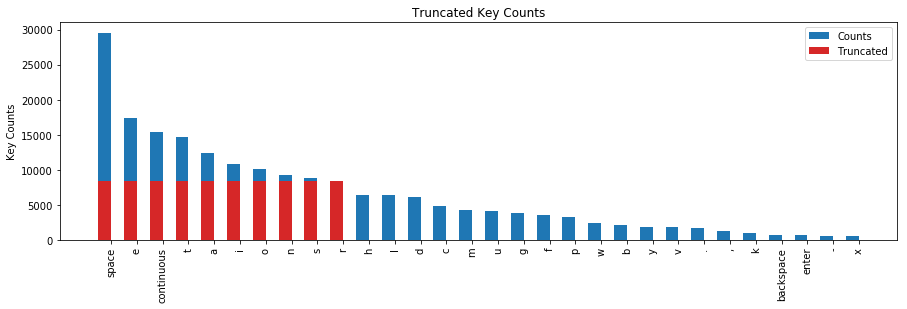

In [13]:
helper.plot_trunc_key_cnt(key_count.most_common(), truncated_count.most_common())

#### Shuffle data

In [14]:
df = df.sample(frac=1).reset_index(drop=True)

### One Hot Encode Classes
<img src="assets/one_hot_encoding.jpg" style="width: 200px;"/>

In [15]:
n_classes = len(set(df['key']))

labels_str = [str(key) for key in df['key']]
lb = preprocessing.LabelBinarizer() # Create encoder
lb.fit(list(set(labels_str)))
labels = lb.transform(labels_str)

In [16]:
lb.classes_

array(['a', 'continuous', 'e', 'i', 'n', 'o', 'r', 's', 'space', 't'],
      dtype='<U10')

In [17]:
# Save label set
pickle.dump(lb.classes_, open(os.path.join(dataset_dir, 'labels.p'), "wb"))

### Cross Validation: Training, Validation, and Test Sets

In [18]:
input_data = df['data'].values
input_data = np.stack(input_data, axis=0)

In [19]:
from sklearn.model_selection import train_test_split
train_features, temp_features, train_labels, temp_labels = train_test_split(input_data, labels, test_size=0.1, random_state=42)
test_features, valid_features, test_labels, valid_labels = train_test_split(temp_features, temp_labels, test_size=0.5, random_state=42)

### Normalize Data
Normalization should be performed on the training set. All other test sets should be normalized to parameters fit from the training set's scaler.

#### Normalize Training Set and Fit Scaler

In [20]:
"""
Careful with MinMaxScaler. 
You specifically wan't to use the fit then transform or fit_transform function on the training set only.
On any of the test cross validation sets or prediction data, you DON'T want to fit() or fit_transform().
This would reset the fit of the scaler that we fit with the training set data.
Use the transform() function on the test sets.
"""
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(train_features) # Compute the minimum and maximum to be used for later scaling.
#train_features = scaler.fit_transform(train_features)
train_features = scaler.transform(train_features)

C:\Users\stephen\AppData\Local\conda\conda\envs\tfgpu1.1\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
train_features.shape

(75510, 10240)

In [22]:
# Reshape for 1 channel of audio data
train_features = train_features.reshape((train_features.shape[0], train_features.shape[1], 1))
# labels = labels.reshape((labels.shape[0], labels.shape[1], 1))
train_features.shape

(75510, 10240, 1)

In [23]:
# Save scaler for later scaling on test sets. scaler.fit() saved the min max values
pickle.dump(scaler, open(os.path.join(dataset_dir, 'scaler.p'), "wb"))

#### Normalize Validation Set

In [24]:
valid_features = scaler.transform(valid_features) # Don't use fit_transform() on test sets, use transform()

# Reshape for 1 channel of audio data
valid_features = valid_features.reshape((valid_features.shape[0], valid_features.shape[1], 1))

# Define Network

### Input

In [25]:
def model_inputs(data_width, n_classes):
    """
    Create the model inputs
    :param data_width: The total number of samples in the recorded data point
    :param n_classes: Number of Classes
    :return: Tuple of (tensor of input audio data, key press labels, learning rate, keep_prob)
    """
    # TODO: Add audio channels to input
    
    with tf.name_scope("Inputs"):
        audio_inputs = tf.placeholder(tf.float32, [None, data_width, 1], name='inputs')
    with tf.name_scope("Targets"):
        key_labels = tf.placeholder(tf.float32, [None, n_classes], name='labels')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_probability')

    return audio_inputs, key_labels, learning_rate, keep_prob

### Get Batches

In [26]:
def get_batches(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

### Network

In [27]:
def network(X, keep_prob, n_classes):
    """
    Create the network
    :param X: Tensor of input recording(s)
    :param keep_prob: Tensor for the keep probability
    :param n_classes: Number of Classes
    :return: Tuple of (tensor output of the classifier, tensor logits of the classifier)
    """    
    # Hyperparameters
    alpha = 0.2
    h_dim = 32
    
    #print("X: {}".format(X.shape))
     
    with tf.name_scope("Hidden_Layer1"):
        #h1 = tf.layers.dense(X, h_dim, activation=None)
        h1 = tf.layers.conv1d(X, h_dim, 200, 10, 'same', activation=None)
        h1 = tf.layers.max_pooling1d(h1, 5, 2, 'same')
        h1 = tf.nn.dropout(h1, keep_prob) # Regularization
        h1 = tf.maximum(h1*alpha, h1) # Leaky ReLu
        h1 = tf.layers.batch_normalization(h1)
        
    #print("h1: {}".format(h1.shape))

    with tf.name_scope("Hidden_Layer2"):
        #h2 = tf.layers.dense(h1, h_dim, activation=None)
        h2 = tf.layers.conv1d(h1, h_dim*2, 50, 5, 'same', activation=None)
        #h2 = tf.layers.maxpool2d(h2, 5, 2, 'same')
        h2 = tf.nn.dropout(h2, keep_prob) # Regularization        
        h2 = tf.maximum(h2*alpha, h2) # Leaky ReLu
        h2 = tf.layers.batch_normalization(h2)
        
    #print("h2: {}".format(h2.shape))

    with tf.name_scope("Hidden_Layer3"):
        #h3 = tf.layers.dense(h2, h_dim, activation=None)
        h3 = tf.layers.conv1d(h2, h_dim*3, 20, 2, 'same', activation=None)
        #h3 = tf.layers.maxpool2d(h3, 3, 2, 'same')
        h3 = tf.nn.dropout(h3, keep_prob) # Regularization
        h3 = tf.maximum(h3*alpha, h3) # Leaky ReLu
        h3 = tf.layers.batch_normalization(h3)
        
    with tf.name_scope("Hidden_Layer4"):
        h4 = tf.layers.conv1d(h3, h_dim*4, 10, 1, 'same', activation=None)
        h4 = tf.nn.dropout(h4, keep_prob) # Regularization
        h4 = tf.maximum(h4*alpha, h4) # Leaky ReLu
        h4 = tf.layers.batch_normalization(h4)
    
    
    
    with tf.name_scope("Output"):
        flat_dim = int(h4.get_shape()[1])*int(h4.get_shape()[2])
        flat = tf.reshape(h4, [-1, flat_dim])
        #print("flat: {}".format(flat.shape))
        logits = tf.layers.dense(flat, n_classes, activation=None, name='logits')
        #print("logits: {}".format(logits.shape))
        #out = tf.nn.softmax(logits, name='softmax_out')

    return logits

### Show Stats

In [28]:
def print_stats(session, feature_batch, label_batch, cost, accuracy, esi):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    : esi: Epochs since the last improvement
    """
    with tf.name_scope("Validation_Stats"):
        valid_trunc_len = min(1000, len(valid_features))
        train_trunc_len = min(1000, len(train_features))
        
        validation_loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
        validation_accuracy = session.run(accuracy, feed_dict={x: valid_features[:valid_trunc_len], y: valid_labels[:valid_trunc_len], keep_prob: 1.0})
        train_accuracy = session.run(accuracy, feed_dict={x: train_features[:train_trunc_len], y: train_labels[:train_trunc_len], keep_prob: 1.0})
        print("Train Accuracy: {0:0.4f}, Validation Accuracy: {1:0.4f}, Validation Loss: {2:0.4f}, ESI: {3}".format(train_accuracy, validation_accuracy, validation_loss, esi))
        return validation_accuracy

### Build Neural Network

In [29]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x, y, learn_rate, keep_prob = model_inputs(data_width, n_classes)

#Model
logits = network(x, keep_prob, n_classes)

with tf.name_scope("Cost"):
    # Cost and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name='loss'), name='cost')
    
with tf.name_scope("Train"):
    optimizer = tf.train.AdamOptimizer(learn_rate, name='optimizer').minimize(cost)

with tf.name_scope("Accuracy"):
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1), name='prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
predicted = tf.nn.softmax(logits, name='predicted')

### Write out the graph for TensorBoard

In [30]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('./logs/2', sess.graph)

### Hyperparameters

In [38]:
epochs = 50000000
batch_size = 16
keep_probability = 0.60
learning_rate = 0.0001

# Train Neural Network

In [39]:
# Accuracy to beat (Min of 3 classes)
print("{:.3}%".format((1/n_classes)*100))

10.0%


In [ ]:
save_path = "checkpoints/model.ckpt"

max_validation_accuracy = 0.0
epochs_since_improvement = 0
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    saver.restore(sess, save_path)
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for batch_features, batch_labels in get_batches(train_features, train_labels, batch_size):
            sess.run(optimizer, feed_dict={x: batch_features, 
                                           y: batch_labels, 
                                           learn_rate: learning_rate, 
                                           keep_prob: keep_probability})
        if epoch % 1 == 0:
            print('Epoch {}: '.format(epoch), end='')
            validation_accuracy = print_stats(sess, batch_features, batch_labels, cost, accuracy, epochs_since_improvement)         
        
            if validation_accuracy > max_validation_accuracy:
                max_validation_accuracy = validation_accuracy
                epochs_since_improvement = 0
                saver.save(sess, save_path)
            else:
                epochs_since_improvement += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
Epoch 0: Train Accuracy: 0.5880, Validation Accuracy: 0.5740, Validation Loss: 1.5372, ESI: 0
Epoch 1: Train Accuracy: 0.5860, Validation Accuracy: 0.5740, Validation Loss: 1.5880, ESI: 0
Epoch 2: Train Accuracy: 0.5840, Validation Accuracy: 0.5720, Validation Loss: 1.4929, ESI: 1
Epoch 3: Train Accuracy: 0.5880, Validation Accuracy: 0.5810, Validation Loss: 1.6795, ESI: 2
Epoch 4: Train Accuracy: 0.5930, Validation Accuracy: 0.5700, Validation Loss: 1.5493, ESI: 0
Epoch 5: Train Accuracy: 0.5890, Validation Accuracy: 0.5650, Validation Loss: 1.7520, ESI: 1
Epoch 6: Train Accuracy: 0.5760, Validation Accuracy: 0.5710, Validation Loss: 1.6257, ESI: 2
Epoch 7: Train Accuracy: 0.5930, Validation Accuracy: 0.5720, Validation Loss: 1.6177, ESI: 3
Epoch 8: Train Accuracy: 0.5820, Validation Accuracy: 0.5690, Validation Loss: 1.6509, ESI: 4
Epoch 9: Train Accuracy: 0.5780, Validation Accuracy: 0.5590, Validation Loss: 1.5930, ES

Epoch 85: Train Accuracy: 0.5860, Validation Accuracy: 0.5640, Validation Loss: 1.3891, ESI: 74
Epoch 86: Train Accuracy: 0.5950, Validation Accuracy: 0.5700, Validation Loss: 1.5667, ESI: 75
Epoch 87: Train Accuracy: 0.5880, Validation Accuracy: 0.5640, Validation Loss: 1.6581, ESI: 76
Epoch 88: Train Accuracy: 0.5880, Validation Accuracy: 0.5730, Validation Loss: 1.6311, ESI: 77
Epoch 89: Train Accuracy: 0.5950, Validation Accuracy: 0.5710, Validation Loss: 1.5984, ESI: 78
Epoch 90: Train Accuracy: 0.5890, Validation Accuracy: 0.5760, Validation Loss: 1.5382, ESI: 79
Epoch 91: Train Accuracy: 0.5960, Validation Accuracy: 0.5750, Validation Loss: 1.5798, ESI: 80
Epoch 92: Train Accuracy: 0.5900, Validation Accuracy: 0.5720, Validation Loss: 1.6674, ESI: 81
Epoch 93: Train Accuracy: 0.5940, Validation Accuracy: 0.5700, Validation Loss: 1.5752, ESI: 82
Epoch 94: Train Accuracy: 0.5850, Validation Accuracy: 0.5760, Validation Loss: 1.6515, ESI: 83
Epoch 95: Train Accuracy: 0.5940, Valida

# Test Set Accuracy

In [37]:
scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb")) # Load saved normalization scaler
normalized_data = scaler.transform(test_features) # Don't use fit_transform on test sets

# Reshape for 1 channel of audio data
normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [38]:
tf.reset_default_graph()

loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    graph = tf.get_default_graph()
    
    x = graph.get_tensor_by_name("Inputs/inputs:0")
    y = graph.get_tensor_by_name("Targets/labels:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    accuracy = graph.get_tensor_by_name("Accuracy/accuracy:0")
    
    test_accuracy = sess.run(accuracy, feed_dict={x: normalized_data, y: test_labels, keep_prob: 1.0})
    print("Test Accuracy: {0:0.3f}".format(test_accuracy))
        

INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt
Test Accuracy: 0.596


# Test Model

In [3]:
test_set = pd.read_pickle(os.path.join(dataset_dir, "test_set.pkl"))
min_thresh_keys = pickle.load(open(os.path.join(dataset_dir, "key_classes.p"), "rb"))
test_set = test_set[test_set['key'].isin(min_thresh_keys)] # Filter dataframe to only include keys > threshold
data_width = len(test_set['data'].values[0])

In [4]:
# input_data = test_set['data'].values[5:6]
# input_data = np.stack(input_data, axis=0)

# scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))
# normalized_data = scaler.transform(input_data)

# # Reshape for 1 channel of audio data
# normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [5]:
input_data = test_set['data'].values
input_data = np.stack(input_data, axis=0)

scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))
normalized_data = scaler.transform(input_data)

normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

In [6]:
loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    graph = tf.get_default_graph()
    
    x = graph.get_tensor_by_name("Inputs/inputs:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    predicted = graph.get_tensor_by_name("predicted:0")
    
    feed_dict = {x: normalized_data, keep_prob: 1.0}
    prediction = sess.run(predicted, feed_dict=feed_dict).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt


In [43]:
# test_set['key'].values[5:6]

In [44]:
# labels[np.argmax(prediction)]

In [45]:
labels = pickle.load(open(os.path.join(dataset_dir, 'labels.p'), "rb"))

In [46]:
correct_cnt = 0
for i, r in enumerate(prediction):
    actual_key = test_set['key'].values[i]
    pred_key = labels[np.argmax(r)]
    print('Key: {0}, Prediction: {1}, Probability: {2:0.2f}'.format(actual_key, pred_key, r[np.argmax(r)]))
    if actual_key == pred_key:
        correct_cnt += 1
print('Accuracy: {}'.format(correct_cnt/len(test_set)))

Key: a, Prediction: s, Probability: 0.45
Key: o, Prediction: n, Probability: 0.47
Key: s, Prediction: s, Probability: 0.52
Key: t, Prediction: e, Probability: 0.29
Key: space, Prediction: space, Probability: 0.98
Key: e, Prediction: r, Probability: 0.40
Key: a, Prediction: a, Probability: 0.57
Key: e, Prediction: r, Probability: 0.22
Key: n, Prediction: n, Probability: 0.73
Key: space, Prediction: space, Probability: 1.00
Key: e, Prediction: e, Probability: 0.83
Key: s, Prediction: a, Probability: 0.44
Key: t, Prediction: t, Probability: 0.50
Key: space, Prediction: space, Probability: 1.00
Key: i, Prediction: i, Probability: 0.86
Key: r, Prediction: n, Probability: 0.20
Key: i, Prediction: i, Probability: 0.39
Key: n, Prediction: n, Probability: 0.47
Key: i, Prediction: n, Probability: 0.28
Key: a, Prediction: a, Probability: 0.89
Key: space, Prediction: space, Probability: 0.99
Key: e, Prediction: e, Probability: 0.25
Key: space, Prediction: space, Probability: 0.83
Key: r, Predictio

# Debug Data

In [13]:
from keyaudio import KeyAudio
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import pickle
import time

dataset_dir = 'DataSet/'

labels = pickle.load(open(os.path.join(dataset_dir, 'labels.p'), "rb"))
print(labels)

# Import a subset of the training set.
# This will be used for normalizing the sampled data
for filename in os.listdir(dataset_dir):
    if filename.endswith("test_set.pkl"):
        continue
    if filename.endswith(".pkl"):
        df_norm = pd.read_pickle(os.path.join(dataset_dir, filename))
        break


scaler = pickle.load(open(os.path.join(dataset_dir, 'scaler.p'), "rb"))

data_width = len(df_norm['data'][0])

"""
    df          Key press audio sample as dataframe
"""
def normalize_data(df):
    input_data = df['data'].values  # Convert to numpy array
    input_data = np.stack(input_data, axis=0)  # Create numpy matrix from array of arrays

    # Normalize data
    normalized_data = scaler.transform(input_data)

    normalized_data = normalized_data.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))
    return normalized_data

def reset_sample():
    key.df_list = []
    key.sample_ready = False

# Load TensorFlow Graph
loader = tf.train.import_meta_graph('checkpoints/model.ckpt.meta')
with tf.Session() as sess:
    loader.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    graph = tf.get_default_graph()

    x = graph.get_tensor_by_name("Inputs/inputs:0")
    keep_prob = graph.get_tensor_by_name("keep_probability:0")
    predicted = graph.get_tensor_by_name("predicted:0")

    # Start Listener
    key = KeyAudio(mode="Sample", save_wav=False)
    print(key.get_dev_info())
    key.startListener()

    count = 1
    correct_cnt = 0
    while key.running:
        if key.sample_ready == True:
            df = pd.DataFrame.from_records(key.df_list) # Key press audio sample

            # Ignore keys not in the label classes
            if not(df['key'].values[0] in labels):
                print("Key skipped. Not in label set.")
                reset_sample()
                continue

            normalized_data = normalize_data(df)  # Normalized audio sample

            # Make Prediction
            feed_dict = {x: normalized_data, keep_prob: 1.0}
            prediction = sess.run(predicted, feed_dict=feed_dict).squeeze()

            print(prediction)
            predicted_key = labels[np.argmax(prediction)]
            print('Prediction: {0}'.format(predicted_key))

            if df['key'].values[0] == predicted_key:
                correct_cnt += 1
            print('Count: {0}, Accuracy: {1:0.2f}'.format(count, correct_cnt/count))

            # Reset relevant class parameters
            reset_sample()
            count += 1

['a' 'e' 'i' 'n' 'o' 's' 'space' 't']
INFO:tensorflow:Restoring parameters from checkpoints\model.ckpt
Instantiating...
{'defaultSampleRate': 44100.0, 'maxInputChannels': 2, 'defaultHighInputLatency': 0.18, 'maxOutputChannels': 0, 'hostApi': 0, 'structVersion': 2, 'name': 'Microphone (Logitech USB Microp', 'defaultLowOutputLatency': 0.09, 'defaultHighOutputLatency': 0.18, 'index': 1, 'defaultLowInputLatency': 0.09}
Starting listener...
Key.space
[  7.76624875e-05   1.27917629e-05   5.41154914e-05   1.37708768e-01
   3.15363957e-09   2.03189880e-01   4.62370235e-06   6.58952117e-01]
Prediction: t
Count: 1, Accuracy: 0.00


In [10]:
type(df)

pandas.core.frame.DataFrame

In [14]:
normalize_data(df)

array([[[ 0.4008316 ],
        [ 0.42523176],
        [ 0.44717633],
        ..., 
        [ 0.55589823],
        [ 0.56717557],
        [ 0.6157276 ]]])

In [12]:
normalized_data

array([[[ 0.397921  ],
        [ 0.42321644],
        [ 0.44948137],
        ..., 
        [ 0.43369314],
        [ 0.44007634],
        [ 0.47588164]]])